# Unità: Word2Vec

In [1]:
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE 

### Scarica il file http://mattmahoney.net/dc/text8.zip

Sono la lista di parole estratte da Wikipedia (inglese) troncate ai primi 100Mb.

In [ ]:
url = 'http://mattmahoney.net/dc/'

In [2]:
def maybe_download(filename, expected_bytes):
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception('Failed to verify ' + filename)
  return filename

# attenzione: ora il file lo trovate nella cartella seguente
filename = maybe_download('data/text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
  # estrai il file zip
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [4]:
# parole da considerare nel dizionario
vocabulary_size = 50000

# costruisco un dizionario dove le parole 
# molto rare sono rimosse assumendo label UNK 
def build_dataset(words):
  count = [['UNK', -1]]
  # estraggo una lista di key-value, dove 
  # key e' la parola e value le occorrenze della parola
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  
  # definisco e inizializza un dizionario di parole
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    # data e' una lista di indici (corrispondenti alle posizioni nel dizionario)
    # rappresenta il testo iniziale rappresentato da indici.
    data.append(index)
  count[0][1] = unk_count
  # creo un nuovo dizionario che, data una posizione (id-parola), mi restituisce una parola
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  # controlli indici
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

  span = 2 * skip_window + 1 
  # formato finestra [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)

  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    
  for i in range(batch_size // num_skips):
    target = skip_window  
    # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['originated', 'anarchism', 'a', 'term', 'originated', 'as', 'term', 'of']


In [10]:
batch_size = 128 
embedding_size = 128 # Dimensione spazio semantico (o dimensione vettori embeddings)
skip_window = 1 # Numero di parole da considerare a sx e dx
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Il numero di parole random da usare per valutare la similarita'
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Numero di esempi negativi da considerare (vedi sampled softmax)

# softmax_weights: A Tensor of shape [num_classes, dim].
# softmax_biases: A Tensor of shape [num_classes]. The class biases.
# embed: A Tensor of shape [batch_size, dim].
# train_labels: A Tensor of shape [batch_size, 1]. The target classes T.
# num_sampled: An int. The number of classes to randomly sample per batch. the numbed of classes in S.
# vocabulary_size: The number of possible classes.
# sampled_values: default to log_uniform_candidate_sampler
    
graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  # Le classi target 
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Inizializzo i parametri della rete
  # 1 hidden layer
  # Tensore vocabulary_size x semantic_space    
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  # output layer: tensore vocabulary_size x semantic_space
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # La codifica onehot impiegata non contiene tutti gli elementi, 
  # ma solo la lista delle posizioni degli elementi pari 1.
  # Es. [0 0 1 0 0 0] -> [2] (posizione indice 2)
  # Per questo si impiega l'operatore embedding_lookup, invece della tradizionale matmul.
  # Si chiama _lookup perche' lo possiamo interpretare come la ricerca della riga/colonna con l'indice dato.
  # Es. [0 0 1 0 0 0] * Mat -> 3a riga di Mat
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    
  # L'operatore sampled_softmax_loss calcola la softmax loss, usando solo un campione random di label = 0.
  # E' una approssimazione ma rende il procedimento molto piu' veloce quando ci sono molte classi.
  # Approfondimenti: https://www.tensorflow.org/extras/candidate_sampling.pdf
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Vogliamo ottimizzare sia i softmax_weights che embeddings.
  # Adagrad e' particolarmente adatto a dati altamente sparsi. 
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Normalizzo 
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
        
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.335362
Nearest to its: gabonese, theropod, psychoanalyst, whit, inexpensive, doesn, squadron, bub,
Nearest to after: pringle, dor, expositor, filtered, poppies, hindustani, reichstag, irresistible,
Nearest to there: herold, informants, ikea, working, glasnevin, myasthenic, dov, layer,
Nearest to his: agm, heterozygote, clinics, cosmetic, darfur, creeping, ungrammatical, spoofs,
Nearest to by: erectus, deviations, domain, connection, vauban, prague, yeast, stimulates,
Nearest to with: defy, maneuverability, eine, reproductions, mane, lillard, muonium, boasting,
Nearest to UNK: zoo, specificity, avro, harbors, rucker, dench, divorces, certification,
Nearest to these: stamping, buttocks, insider, pogroms, macleod, evans, mi, trillion,
Nearest to b: hinge, beet, cuyahoga, admiralty, sequential, neptunian, helens, fertilizer,
Nearest to at: salon, buy, table, hornets, veneto, jeffersonian, gnumeric, flap,
Nearest to would: geelong, korea, abuse, cunha, 

Average loss at step 52000: 3.434917
Average loss at step 54000: 3.423604
Average loss at step 56000: 3.439892
Average loss at step 58000: 3.400276
Average loss at step 60000: 3.393606
Nearest to its: their, his, the, her, amato, ionizing, our, disruptive,
Nearest to after: before, during, when, despite, without, under, while, following,
Nearest to there: they, it, now, he, still, often, she, we,
Nearest to his: her, their, its, my, the, rigidly, our, wal,
Nearest to by: through, bulgar, was, after, foster, with, using, deviations,
Nearest to with: between, including, load, ftc, depressive, by, helsingborg, when,
Nearest to UNK: detoxification, carver, chakra, idealists, wikiquote, kusakabe, tei, pascal,
Nearest to these: some, many, several, such, which, all, those, they,
Nearest to b: d, c, r, f, p, hplc, steep, impregnated,
Nearest to at: during, near, in, reporting, postcolonial, punt, suzaku, after,
Nearest to would: could, will, may, can, should, must, might, cannot,
Nearest to y

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

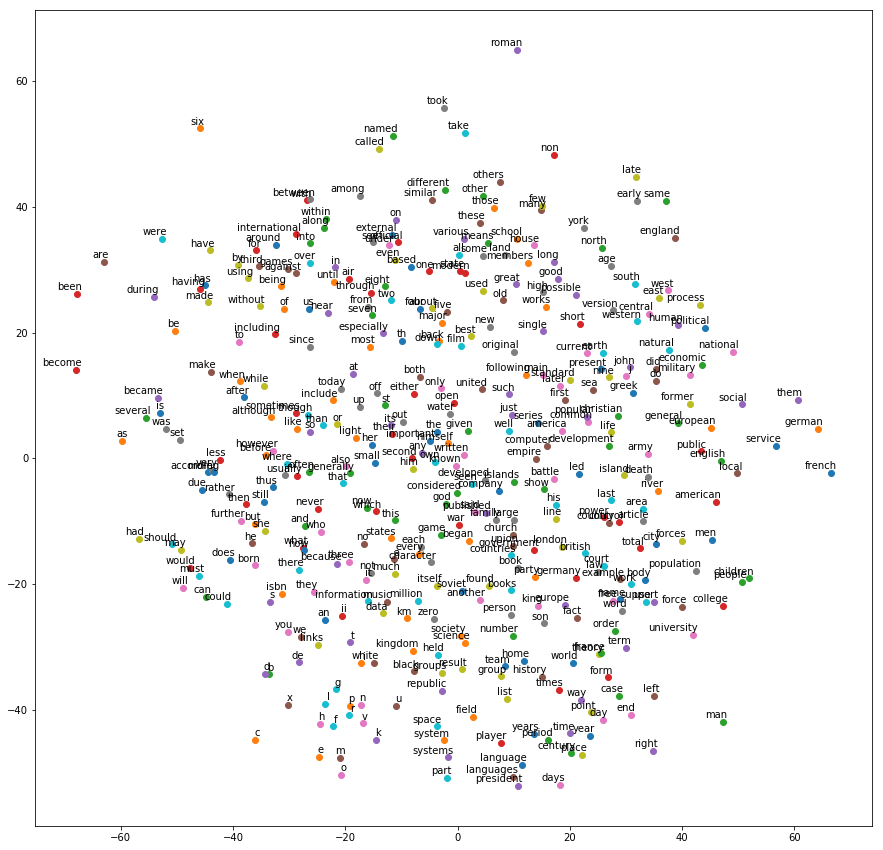

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)